# IMPORTS

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

from datetime import datetime, date
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

# PLOTTING PARAMETERS

In [2]:
tex_fonts = {
        "text.usetex": True,
        "font.family": "serif",
        "axes.titlesize": 10, 
        "axes.labelsize": 10,
        "font.size": 10,
        "legend.fontsize": 'xx-small',
        "legend.title_fontsize": 10,
        "xtick.labelsize": 8, #'xx-small',
        "ytick.labelsize": 8, #'xx-small',
        "ps.usedistiller": "xpdf"
        }
plt.rcParams.update(tex_fonts)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amssymb,underscore}'

cm=1/2.54

# PATHS

In [3]:
path_data = Path('./input')

In [4]:
path_plots = Path('./plots')

# FUNCTIONS

In [5]:
def plot_ts_split(ts_cv, X, y, path, filename, cm):
    
    fig, ax = plt.subplots(figsize=(10*cm, 5*cm))
    
    for i, (train, test) in enumerate(ts_cv.split(X, y)):
        ax_train = ax.scatter(train, [i] * len(train), c='black', marker="_", lw=8)
        ax_test  = ax.scatter(test, [i] * len(test), c='red', marker="_", lw=8)
    
    ax.set(
        title="Time-series split",
        xlabel="Data Index",
        ylabel="Cross-validation iteration",
        ylim=[5, -1],
    )
    ax.legend([ax_train, ax_test], ["Training", "Testing"])
    
    fig.tight_layout()
    file = path / str(filename)
    fig.savefig(file, format='pdf')

In [6]:
def ts_cv_score(X , y, n_split, n_est, plot_ts, path, cm):
    
    # plot_ts is True/False, decides wheteher the splitting of time series has to be shown  
    
    from sklearn.model_selection import TimeSeriesSplit, cross_validate
    from sklearn.ensemble import RandomForestRegressor
    
    # Initialize time series split
    ts_cv = TimeSeriesSplit(n_splits=n_split) 
    
    if plot_ts:
        plot_ts_split(ts_cv, X, y, path_plots, 'time-series_splitting_'+ str(n_split) + '_iterations.pdf', cm)    
    
    # Initialize random forest regressor
    rf = RandomForestRegressor(n_estimators=n_est, random_state=1121218)

    scores = cross_validate(rf, X, y, cv=ts_cv, scoring="neg_mean_squared_log_error", return_estimator=True)

    # Base RMSLE
    base_rmsle = np.sqrt(-np.mean(scores["test_score"]))
    
    print("Base Root Meat Squared Log Error is: {:.5f}".format(base_rmsle))

# DATA

## Clean data

In [7]:
# IMPORT CLEAN DATA FROM THE data_cleaning notebook

input_filename = path_data / 'clean_data.gz'
data = pd.read_csv(input_filename, 
                   compression=dict(method='gzip'),
                   index_col='index',
                   dtype={#'store_nbr': 'category',
                          'dayname': 'category',
                         },
                   parse_dates=['date'],
                   infer_datetime_format=True,
                  ) 
data['date'] = pd.to_datetime(data['date'])
'''
csv I/O removes any categorical information (categories and ordering). 
Such info has to be re initialized, or stored in a hdf files
'''
listdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
liststore = list(range(1, 55))
# pd.Categorical() to set the order according to the 'days' list
data.dayname = pd.Categorical(data.dayname, categories=listdays, ordered=True)
data.store_nbr = pd.Categorical(data.store_nbr, categories=liststore, ordered=True)
data['dayofmonth'] = data.date.dt.day

data.head()

/tmp/ipykernel_36548/2502291277.py:4: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(input_filename,


,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,locale,...,dayname,dayofyear,week,year,Terremoto,Futbol,CyberMonday,BlackFriday,Madre,dayofmonth
index,,,,,,,,,,,,,,,,,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,National,...,Tuesday,1,1,2013,False,False,False,False,False,1
1,2016-01-01,21,POULTRY,0.0,0,Santo Domingo,Santo Domingo de los Tsachilas,B,6,National,...,Friday,1,53,2016,False,False,False,False,False,1
2,2016-01-01,21,PREPARED FOODS,0.0,0,Santo Domingo,Santo Domingo de los Tsachilas,B,6,National,...,Friday,1,53,2016,False,False,False,False,False,1
3,2016-01-01,21,PRODUCE,0.0,0,Santo Domingo,Santo Domingo de los Tsachilas,B,6,National,...,Friday,1,53,2016,False,False,False,False,False,1
4,2016-01-01,21,SCHOOL AND OFFICE SUPPLIES,0.0,0,Santo Domingo,Santo Domingo de los Tsachilas,B,6,National,...,Friday,1,53,2016,False,False,False,False,False,1


## Stores data

In [8]:
stores = pd.read_csv(
    path_data / 'stores.csv',
    dtype={'store_nbr': 'category',
           'city': 'category',
           'state': 'category',
           'type': 'category',
           'cluster': 'category'
           },
    )
# type already use as column name
stores.rename(columns={'type': 'store_type'}, inplace=True)
stores.head()

,store_nbr,city,state,store_type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


## Test data

In [9]:
test_in = pd.read_csv(
    path_data / 'test.csv',
    usecols=['store_nbr', 'family', 'date', 'onpromotion'],
    dtype={'store_nbr': 'category',
           'family': 'category',
           'onpromotion': 'uint32',
          },
    parse_dates=['date'],
    infer_datetime_format=True,
    )

pd.to_datetime(test_in['date'])
test_in.head()

,date,store_nbr,family,onpromotion
0,2017-08-16,1,AUTOMOTIVE,0
1,2017-08-16,1,BABY CARE,0
2,2017-08-16,1,BEAUTY,2
3,2017-08-16,1,BEVERAGES,20
4,2017-08-16,1,BOOKS,0


In [10]:
# Merge test and stores
test2 = test_in.merge(stores, on='store_nbr', how='left')
test2.head()

,date,store_nbr,family,onpromotion,city,state,store_type,cluster
0,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13
1,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13
2,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13
3,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13
4,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13


In [11]:
# Import holidays in the test data
hol_test = pd.read_csv(path_data / 'hol_test.csv',
                       usecols = ['date', 'locale', 'locale_name', 'status', 'Terremoto', 'Futbol', 'CyberMonday', 'BlackFriday', 'Madre'],
                       dtype={#'store_nbr': 'category',
                              'dayname': 'category',
                              },
                       parse_dates=['date'],
                       infer_datetime_format=True,
                      ) 
hol_test['date'] = pd.to_datetime(hol_test['date'])
hol_test

,date,locale,locale_name,status,Terremoto,Futbol,CyberMonday,BlackFriday,Madre
0,2017-08-24,Local,Ambato,holiday,False,False,False,False,False


In [12]:
# Merge the outcome with holidays
test3 = test2.merge(hol_test, on='date', how='left')

# At this stage we have a lot of NaNs comimg from hol_test
# except the single day with holiday information in the test sample
# this is a local holiday at the city 'Ambato'

# fill in status with 'holiday' only when 'city' == 'locale_name' (i. e., Ambato)
# data in hol_test is simple, so next line is not necessary
# test3.loc[~test3.status.isna() and (test3.city==test3.locale_name), 'status'] = 'holiday'

# else fill in with 'work'
test3.loc[test3.city!=test3.locale_name, 'status'] = 'work'

# fill in NaNs
test3.loc[test3.Terremoto.isna(), 'Terremoto'] = False
test3.loc[test3.Futbol.isna(), 'Futbol'] = False
test3.loc[test3.CyberMonday.isna(), 'CyberMonday'] = False
test3.loc[test3.BlackFriday.isna(), 'BlackFriday'] = False
test3.loc[test3.Madre.isna(), 'Madre'] = False

# add boolean column 'workday'
test3['Workday'] = np.where(test3['status']=='Work', False, True)

# add boolean column 'promotion'
test3['Promotion'] = np.where(test3['onpromotion']>0, False, True)

# drop columns (locale, locale name)
test3.drop(columns=['locale', 'locale_name'], inplace=True)
# sanity check
test3.loc[test3.status=='holiday'].city.unique()

['Ambato']
Categories (22, object): ['Ambato', 'Babahoyo', 'Cayambe', 'Cuenca', ..., 'Quito', 'Riobamba', 'Salinas', 'Santo Domingo']

In [13]:
test3.head()

,date,store_nbr,family,onpromotion,city,state,store_type,cluster,status,Terremoto,Futbol,CyberMonday,BlackFriday,Madre,Workday,Promotion
0,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,work,False,False,False,False,False,True,True
1,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,work,False,False,False,False,False,True,True
2,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,work,False,False,False,False,False,True,False
3,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,work,False,False,False,False,False,True,False
4,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,work,False,False,False,False,False,True,True


# TESTING FORECASTING USING AVERAGE SALES

### Split input data

In [14]:
# Location information
list_locale = ['date', 'store_nbr', 'family', 'city', 'state', 'store_type', 'cluster', 'locale', 'locale_name', 'status']
locale_in = data.loc[:,list_locale]

In [15]:
# indicators
list_indic = ['date', 'onpromotion', 'status', 'Terremoto', 'Futbol', 'CyberMonday', 'BlackFriday', 'Madre']
indic_in = data.loc[:,list_indic]

In [16]:
# Average sales (includes date information as it will not be modified by groupby+mean)
list_sales = ['date', 'sales', 'onpromotion', 'day', 'dayofyear', 'week', 'year', 'dayofmonth']
average_sales = data.loc[:,list_sales]

In [17]:
average_sales = (
    average_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)
average_sales.head()

,sales,onpromotion,day,dayofyear,week,year,dayofmonth
date,,,,,,,
2017-01-01,6.780304,0.095398,6.0,1.0,52.0,2017.0,1.0
2017-01-02,786.928379,6.628507,0.0,2.0,1.0,2017.0,2.0
2017-01-03,619.740224,7.803591,1.0,3.0,1.0,2017.0,3.0
2017-01-04,555.608004,12.860831,2.0,4.0,1.0,2017.0,4.0
2017-01-05,436.375395,4.797980,3.0,5.0,1.0,2017.0,5.0


In [18]:
y = average_sales.sales
y.head()

date
2017-01-01      6.780304
2017-01-02    786.928379
2017-01-03    619.740224
2017-01-04    555.608004
2017-01-05    436.375395
Name: sales, dtype: float64

### Create simple features for dates in averages_sales

In [19]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [20]:
# Create features for dates in averages_sales

fourier = CalendarFourier(freq='M', order=4)

dp = DeterministicProcess(
    index=y.index,                # dates from the training data
    constant=True,               # dummy feature for the bias (y_intercept)
    order=1,                      # the time dummy (trend)
    seasonal=True,                # weekly seasonality (dealt with via indicators) 
    additional_terms = [fourier], # monthly seasonality (dealt with via Fourier coefficients)
    drop=True,                    # drop terms if necessary to avoid collinearity
)

X = dp.in_sample()

In [21]:
print(X.head())

            const  trend  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)  \
date                                                                       
2017-01-01    1.0    1.0     0.0     0.0     0.0     0.0     0.0     0.0   
2017-01-02    1.0    2.0     1.0     0.0     0.0     0.0     0.0     0.0   
2017-01-03    1.0    3.0     0.0     1.0     0.0     0.0     0.0     0.0   
2017-01-04    1.0    4.0     0.0     0.0     1.0     0.0     0.0     0.0   
2017-01-05    1.0    5.0     0.0     0.0     0.0     1.0     0.0     0.0   

            sin(1,freq=M)  cos(1,freq=M)  sin(2,freq=M)  cos(2,freq=M)  \
date                                                                     
2017-01-01       0.000000       1.000000       0.000000       1.000000   
2017-01-02       0.201299       0.979530       0.394356       0.918958   
2017-01-03       0.394356       0.918958       0.724793       0.688967   
2017-01-04       0.571268       0.820763       0.937752       0.347305   
2017-01-05       0.7247

#### We have 1 trend term (const), 7 weekly indicators, and 8 Fourier terms

### Simple fit of averages_sales

In [22]:
model = LinearRegression().fit(X,y)
y_pred = pd.Series(model.predict(X), index=X.index)

In [23]:
def plot_ts_fit(train, fit, xlab, ylab, title, path, filename, cm):
    
    fig = plt.figure(figsize=(18*cm, 12*cm))
    ax = fig.add_subplot(111)
    
    #ax1 = ax.plot(average_sales.dayofyear,average_sales.sales, c='blue', label = 'Training data')
    #ax2 = ax.plot(average_sales.dayofyear,y_pred, c='red')
    ax1 = ax.plot(train.dayofyear,train.sales, c='blue', label = 'Training data')
    ax2 = ax.plot(train.dayofyear,fit, c='red', label = 'Fit to the training data')
    
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    
    ax.legend(title=None,
              loc="upper right",
              )
    
    fig.tight_layout()
    file = path / str(filename)
    fig.savefig(file, format='pdf')

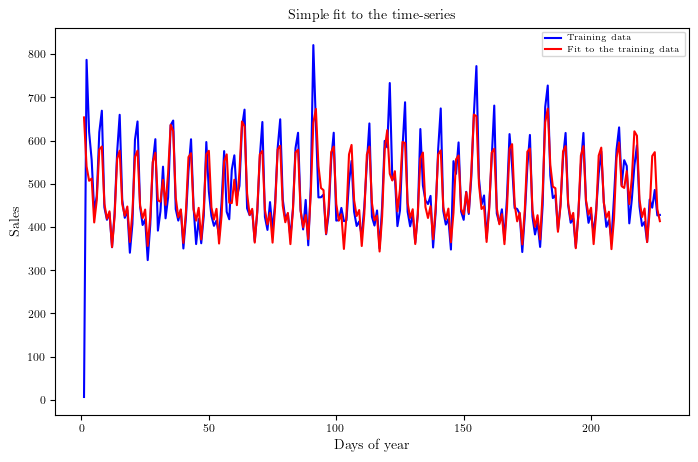

In [24]:
plot_ts_fit(average_sales, y_pred, 'Days of year', 'Sales', 'Simple fit to the time-series', path_plots, 'forecasting_simple_fit.pdf', cm)

Base Root Meat Squared Log Error is: 0.14447


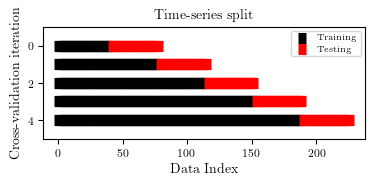

In [25]:
ts_cv_score(X , y, 5, 1000, True, path_plots, cm)

### Add single feature for holidays

In [26]:
holidays_events = pd.read_csv(
    path_data / "holidays_events.csv",
    dtype={'type': 'category',
          'locale': 'category',
          'locale_name': 'category',
          'description': 'category',
          'transferred': 'bool',#
          },
    parse_dates=['date'],
    infer_datetime_format=True,
    )

pd.to_datetime(holidays_events['date'])
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [27]:
mask_date = (holidays_events.date > '2017-01-11') & (holidays_events.date <= '2017-08-15')

In [28]:
temp = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc[mask_date, ['date', 'locale']]
)
temp['holiday'] = 1.0
holidays = temp.drop(columns=['locale']).set_index('date', drop=True)

In [29]:
# average_sales does not contain NaNs, then we can use fillna to fill in the 'work' column for norma working days
X_hol = average_sales.merge(holidays, on='date', how='left').fillna(0.0)['holiday']
X_hol.head()

date
2017-01-01    0.0
2017-01-02    0.0
2017-01-03    0.0
2017-01-04    0.0
2017-01-05    0.0
Name: holiday, dtype: float64

In [30]:
X2 = X.join(X_hol, on='date')
X2.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)",holiday
date,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.0
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967,0.0
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649,0.0
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758,0.0
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869,0.0


In [31]:
model2 = LinearRegression().fit(X2,y)
y_pred2 = pd.Series(model2.predict(X2), index=X2.index)

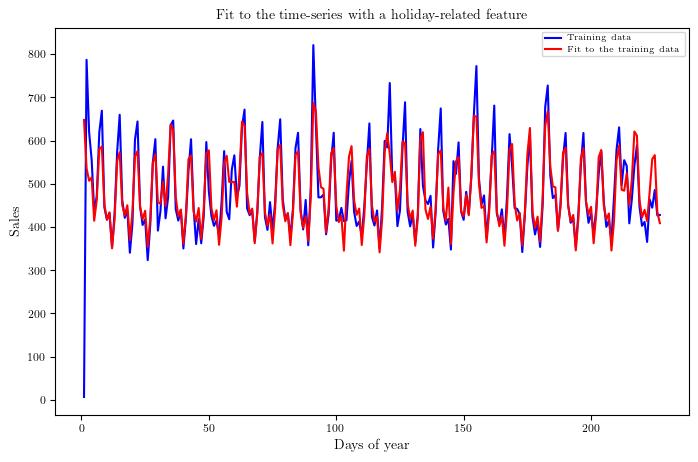

In [32]:
plot_ts_fit(average_sales, y_pred2, 'Days of year', 'Sales', 'Fit to the time-series with a holiday-related feature', path_plots, 'forecasting_holiday_feature_fit.pdf', cm)

Text(0.5, 1.0, 'Difference between predictions')

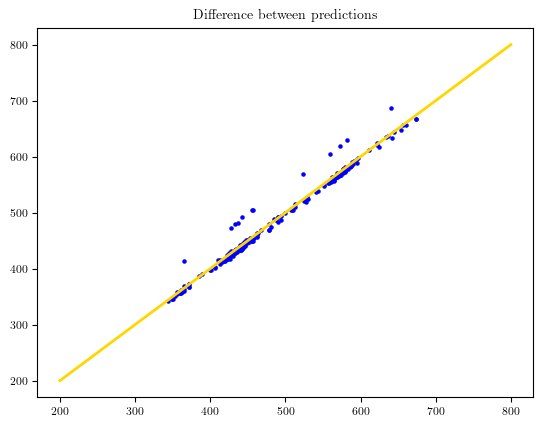

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_pred,y_pred2, s=5, c='blue')
ax.plot([200,800],[200,800], lw=2, c='gold')
ax.set_title(r'Difference between predictions')

In [34]:
ts_cv_score(X2 , y, 5, 1000, False, path_plots, cm)

Base Root Meat Squared Log Error is: 0.14343


### ALTERNATIVE: Add a specific feature for each single holiday

In [35]:
holtest = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc[mask_date, ['date','description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
).set_index('date', drop=True)
holtest.head()

,description
date,
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo


In [36]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)

X_holtest = pd.DataFrame(
    ohe.fit_transform(holtest),
    index = holtest.index,
    columns = holtest.description.unique(),
)


In [37]:
X3 = X.join(X_holtest, on='date').fillna(0.0)

In [38]:
X3.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,Provincializacion de Cotopaxi,Viernes Santo,Dia del Trabajo,Dia de la Madre-1,Dia de la Madre,Batalla de Pichincha,Traslado Batalla de Pichincha,Provincializacion de Imbabura,Primer Grito de Independencia,Traslado Primer Grito de Independencia
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
model3 = LinearRegression().fit(X3,y)
y_pred3 = pd.Series(
    model3.predict(X3),
    index = X3.index,
)

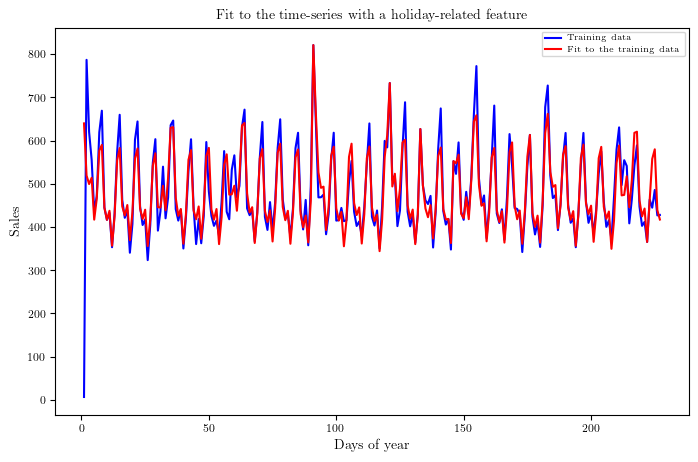

In [40]:
plot_ts_fit(average_sales, y_pred3, 'Days of year', 'Sales', 'Fit to the time-series with a holiday-related feature', path_plots, 'forecasting_holiday_feature_fit.pdf', cm)

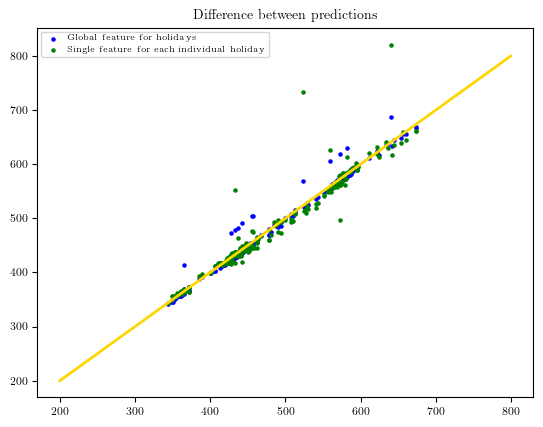

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_pred,y_pred2, s=5, label='Global feature for holidays', c='blue')
ax.scatter(y_pred,y_pred3, s=5, label='Single feature for each individual holiday', c='green')
ax.plot([200,800],[200,800], lw=2, c='gold')
ax.set_title(r'Difference between predictions')
ax.legend(loc='upper left')

In [42]:
ts_cv_score(X3 , y, 5, 1000, False, path_plots, cm)

Base Root Meat Squared Log Error is: 0.14386


### Add Lag feature(s)

#### Partial autocorrelation

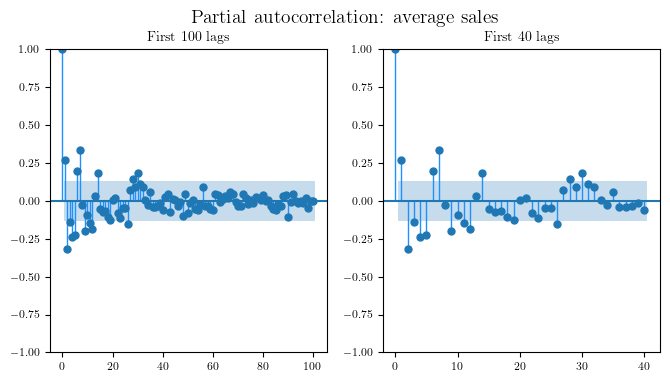

In [43]:
fig, ax = plt.subplots(1,2, figsize=(20*cm, 10*cm))
fig.suptitle("Partial autocorrelation: average sales", fontsize=14)
p1 = sm.graphics.tsa.plot_pacf(average_sales.sales, lags=100, method='ywm', ax=ax[0], \
                                      title = 'First 100 lags', \
                                      vlines_kwargs={'color': 'dodgerblue', 'lw':1})

p2 = sm.graphics.tsa.plot_pacf(average_sales.sales, lags=40, method='ywm', ax=ax[1], \
                                      title = 'First 40 lags', \
                                      vlines_kwargs={'color': 'dodgerblue', 'lw':1})

In [44]:
def get_lags_sorted_by_pacf(ts, nlags, alpha, threshold):
    
    import statsmodels.api as sm

    # return pacf, confidence intervals for the first nlags lags
    pacf1, ci = sm.tsa.pacf(average_sales.sales, nlags=40, alpha=0.05)
    # transform into df
    pacf = pd.DataFrame(pacf1,columns=['value'])
    # get absolute value
    pacf['value'] = pacf['value'].abs()
    # get index as lag identifier
    pacf['lag'] = pacf.index
    # sort by value and keep only the lags above thereshold
    pacf.sort_values(by='value', ascending=False, inplace =True, ignore_index=True)
    
    return pacf.loc[(pacf.value<1.0) & (pacf.value>threshold)]

In [45]:
pacf = get_lags_sorted_by_pacf(average_sales.sales, nlags=40, alpha=0.05, threshold=0.2)
pacf

,value,lag
1,0.353575,7
2,0.321636,2
3,0.272781,1
4,0.242270,4
5,0.235145,30
6,0.233917,5
7,0.214435,14
8,0.212701,9
9,0.207263,28
10,0.202131,12


In [46]:
lag_list = pacf.lag.to_list()
lag_list

[7, 2, 1, 4, 30, 5, 14, 9, 28, 12, 6]

In [47]:
Xlag_init = average_sales.copy()

In [48]:
def create_lag_features(df, column, lag_list):
    
    for lag in lag_list:
        df['lag_' + str(lag)] = df[column].shift(lag).fillna(0.0)
        
    return df 

In [49]:
create_lag_features(Xlag_init, 'sales', lag_list)
Xlag = Xlag_init.drop(columns=['sales', 'onpromotion', 'day', 'week', 'year', 'dayofmonth'])
Xlag

,dayofyear,lag_7,lag_2,lag_1,lag_4,lag_30,lag_5,lag_14,lag_9,lag_28,lag_12,lag_6
date,,,,,,,,,,,,
2017-01-01,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-02,2.0,0.000000,0.000000,6.780304,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-03,3.0,0.000000,6.780304,786.928379,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-04,4.0,0.000000,786.928379,619.740224,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-05,5.0,0.000000,619.740224,555.608004,6.780304,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,223.0,464.520587,411.975126,365.536988,447.511203,420.202018,588.978207,468.630574,541.364768,429.567687,630.613063,541.915629
2017-08-12,224.0,541.915629,365.536988,463.733851,402.786952,353.339710,447.511203,579.299027,408.568173,543.814324,497.113828,588.978207
2017-08-13,225.0,588.978207,463.733851,444.798280,411.975126,429.567687,402.786952,630.613063,464.520587,617.734960,554.729385,447.511203


In [50]:
model_lag = LinearRegression().fit(Xlag,y)
y_pred_lag = pd.Series(
    model_lag.predict(Xlag),
    index = Xlag.index,
)

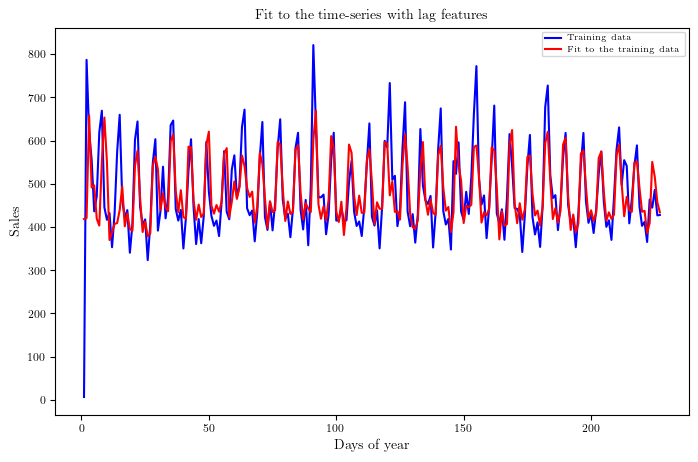

In [51]:
plot_ts_fit(average_sales, y_pred_lag, 'Days of year', 'Sales', \
            'Fit to the time-series with lag features', path_plots, 'forecasting_lag_features_fit.pdf', cm)

In [52]:
ts_cv_score(Xlag , y, 5, 1000, False, path_plots, cm)

Base Root Meat Squared Log Error is: 0.10842


In [53]:
X4 = Xlag.join(X2, on='date').fillna(0.0)
X4.columns

Index(['dayofyear', 'lag_7', 'lag_2', 'lag_1', 'lag_4', 'lag_30', 'lag_5',
       'lag_14', 'lag_9', 'lag_28', 'lag_12', 'lag_6', 'const', 'trend',
       's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)', 's(7,7)',
       'sin(1,freq=M)', 'cos(1,freq=M)', 'sin(2,freq=M)', 'cos(2,freq=M)',
       'sin(3,freq=M)', 'cos(3,freq=M)', 'sin(4,freq=M)', 'cos(4,freq=M)',
       'holiday'],
      dtype='object')

In [54]:
model4 = LinearRegression().fit(X4,y)
y_pred4 = pd.Series(
    model4.predict(X4),
    index = X4.index,
)

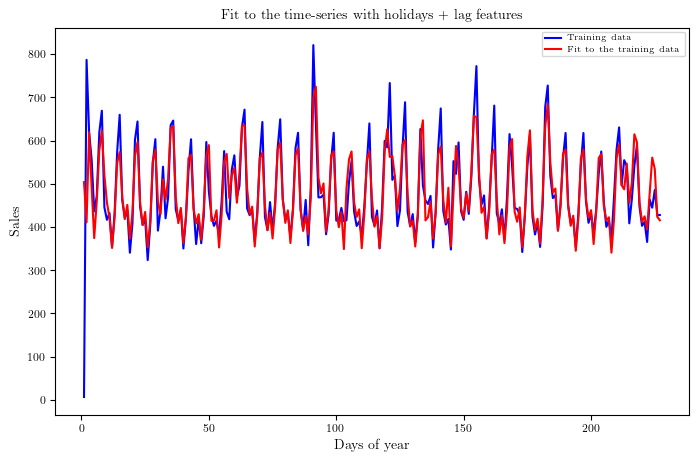

In [55]:
plot_ts_fit(average_sales, y_pred4, 'Days of year', 'Sales', \
            'Fit to the time-series with holidays + lag features', path_plots, 'forecasting_hol+lag_features_fit.pdf', cm)

In [56]:
ts_cv_score(X4 , y, 5, 1000, False, path_plots, cm)

Base Root Meat Squared Log Error is: 0.10437


### Add Promotion feature

In [57]:
Xprom = Xlag_init.drop(columns=['sales', 'day', 'week', 'year', 'dayofmonth'])
Xprom

,onpromotion,dayofyear,lag_7,lag_2,lag_1,lag_4,lag_30,lag_5,lag_14,lag_9,lag_28,lag_12,lag_6
date,,,,,,,,,,,,,
2017-01-01,0.095398,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-02,6.628507,2.0,0.000000,0.000000,6.780304,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-03,7.803591,3.0,0.000000,6.780304,786.928379,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-04,12.860831,4.0,0.000000,786.928379,619.740224,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-05,4.797980,5.0,0.000000,619.740224,555.608004,6.780304,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,7.956790,223.0,464.520587,411.975126,365.536988,447.511203,420.202018,588.978207,468.630574,541.364768,429.567687,630.613063,541.915629
2017-08-12,4.664422,224.0,541.915629,365.536988,463.733851,402.786952,353.339710,447.511203,579.299027,408.568173,543.814324,497.113828,588.978207
2017-08-13,5.209315,225.0,588.978207,463.733851,444.798280,411.975126,429.567687,402.786952,630.613063,464.520587,617.734960,554.729385,447.511203


In [58]:
model_prom = LinearRegression().fit(Xprom,y)
y_pred_prom = pd.Series(
    model_prom.predict(Xprom),
    index = Xprom.index,
)

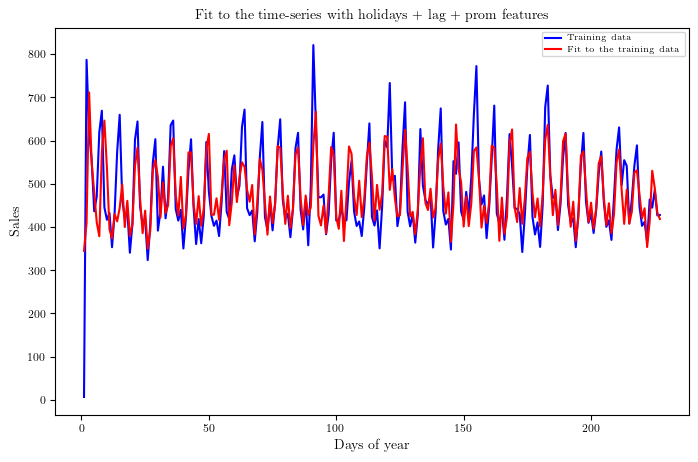

In [59]:
plot_ts_fit(average_sales, y_pred_prom, 'Days of year', 'Sales', \
            'Fit to the time-series with holidays + lag + prom features', path_plots, 'forecasting_hol+lag+prom_features_fit.pdf', cm)

In [60]:
ts_cv_score(Xprom , y, 5, 1000, False, path_plots, cm)

Base Root Meat Squared Log Error is: 0.10849


# Dealing with feature selection

## Importance score

In [61]:
from sklearn.ensemble import RandomForestRegressor

# fit random forest model
model_rf = RandomForestRegressor(n_estimators=1000, random_state=1121218)
model_rf.fit(Xprom, y)


y_pred_rf = pd.Series(
    model_rf.predict(Xprom),
    index = Xprom.index,
)

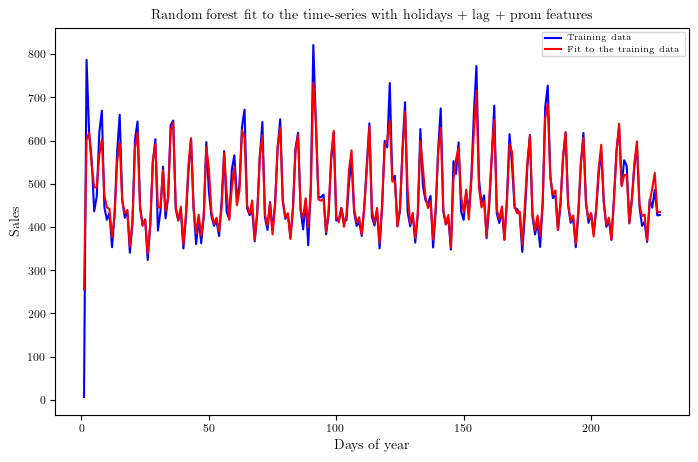

In [62]:
plot_ts_fit(average_sales, y_pred_rf, 'Days of year', 'Sales', \
            'Random forest fit to the time-series with holidays + lag + prom features', path_plots, 'forecasting_(rf)_hol+lag+prom_features_fit.pdf', cm)

In [63]:
ts_cv_score(Xprom , y, 5, 1000, False, path_plots, cm)

Base Root Meat Squared Log Error is: 0.10849


In [64]:
def plot_feature_importance(model_rf, threshold, path, filename, cm):
    
    # model_rf: model using a Random Forest Regressor
    from sklearn.ensemble import RandomForestRegressor

    names = names = Xprom.columns.values
    ticks = [i for i in range(len(names))]
    
    fig = plt.figure(figsize=(10*cm, 8*cm))
    ax = fig.add_subplot(111)
    
    cols = ['red' if x < threshold else 'green' for x in model_rf.feature_importances_]
    sns.barplot(x=model_rf.feature_importances_, y=ticks, palette=cols, orient='h')
    
    #ax.set_xlabel(r'Feature importance')
    ax.set_ylabel(r'Features')
    ax.set_yticks(ticks, names)
    ax.set_title('Feature importance')
    
    
    for p in ax.patches:
        _x = p.get_x() + p.get_width() + 0.01
        _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
        value = '{:.3f}'.format(p.get_width())
        ax.text(_x, _y, value, ha="left", va="center")
        
    fig.tight_layout()
    file = path / str(filename)
    fig.savefig(file, format='pdf')    

[0.05495535 0.05541443 0.27605689 0.07240032 0.07252442 0.02448123
 0.05073003 0.0221922  0.10756179 0.04485025 0.17017416 0.02925411
 0.01940482]


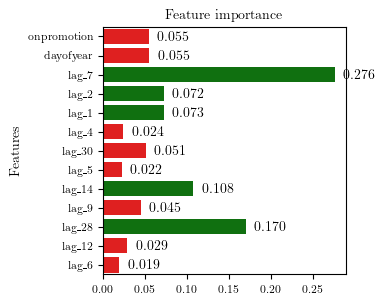

In [65]:
# print importance scores
print(model_rf.feature_importances_)
# plot importance scores
plot_feature_importance(model_rf, 0.06, path_plots, 'feature_importance.pdf', cm)  

# Using Recursive Feature Selection (RFE) to select the most relevant features

In [68]:
def feature_selection_nfeat(X, y, nfeat, path, filename, cm):
    
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.feature_selection import RFE
    
    # feature selection
    rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), n_features_to_select=nfeat)
    fit = rfe.fit(Xprom, y)
    
    names = Xprom.columns.values
    ticks = [i for i in range(len(names))]
    
    # print selected features
    
    #print('Selected Features:')
    #for i in range(len(fit.support_)):
    #    if fit.support_[i]:
    #        print(names[i])
    #    names = names = Xprom.columns.values
    print('selected features:', names[rfe.get_support(indices=False)])
    
    # plot selected features
    fig = plt.figure(figsize=(10*cm, 8*cm))
    ax = fig.add_subplot(111)
    
    cols = ['green' if x < 2 else 'red' for x in fit.ranking_]
    sns.barplot(x=fit.ranking_, palette=cols, y=ticks, orient='h')
    
    ax.set_xlabel(r'Feature ranking')
    ax.set_ylabel(r'Features')
    ax.set_yticks(ticks, names)
    ax.set_title('Feature selection')

    fig.tight_layout()
    file = path / str(filename)
    fig.savefig(file, format='pdf')    

selected features: ['lag_7' 'lag_2' 'lag_1' 'lag_14' 'lag_28']


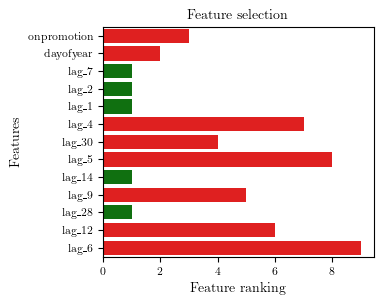

In [69]:
feature_selection_nfeat(Xprom, y, 5, path_plots, 'rfe_feature_selection.pdf', cm)  